The purpose of this notebook is to empirically verify that the way (forward) log probabilities are evaluates, both at s_0 and s != s_0 is valid. The way the sanity check is done is by evaluating Riemaniann sums approximating the integral of the measure, which should be 1

In [196]:
from env import Box, get_last_states
from model import CirclePF, CirclePB, NeuralNet
from sampling import sample_trajectories, evaluate_backward_logprobs, sample_actions
import torch
import numpy as np
import matplotlib.pyplot as plt

In [197]:
env = Box(2, delta=0.1)
model = CirclePF(n_components=2, n_components_s0=4)

bw_model = CirclePB(n_components=2)

In [198]:
dist_r, dist_theta = model.to_dist(torch.zeros(1))
samples_r, samples_theta = dist_r.sample((5,)), dist_theta.sample((5,))

In [199]:
def eval_logprobs_s0(samples_r, samples_theta, without_log_delta=False):
    logprobs = (
            dist_r.log_prob(samples_r)
            + dist_theta.log_prob(samples_theta)
            - torch.log(samples_r * env.delta)
            - np.log(np.pi / 2)
            - 0 if without_log_delta else np.log(env.delta)
        )
    return logprobs

In [200]:
def eval_logprobs(s, samples_sprime):
    exit_proba, dist = model.to_dist(s)
    thetas = torch.acos((samples_sprime[:, 0] - s[0]) / env.delta)
    
    A = torch.where(
            s[0] <= 1 - env.delta,
            0.0,
            2.0 / torch.pi * torch.arccos((1 - s[0]) / env.delta),
        )
    B = torch.where(
        s[1] <= 1 - env.delta,
        1.0,
        2.0 / torch.pi * torch.arcsin((1 - s[1]) / env.delta),
    )
    logprobs = (
            dist.log_prob((thetas * 2 / np.pi - A) / (B - A))
            + torch.log(1 - exit_proba)
            - np.log(env.delta)
            - np.log(np.pi / 2)
            - torch.log(B - A)
        )
    return dist, exit_proba, logprobs


### Make sure P_F(. | s) is a valid proba dist on s' for s != s_0

In [201]:
N = 5000

s = torch.tensor([0.92, 0.3])
# s = torch.tensor([0.15, 0.2])

A = torch.where(
            s[0] <= 1 - env.delta,
            0.0,
            2.0 / torch.pi * torch.arccos((1 - s[0]) / env.delta),
        ).item()
B = torch.where(
    s[1] <= 1 - env.delta,
    1.0,
    2.0 / torch.pi * torch.arcsin((1 - s[1]) / env.delta),
).item()
all_thetas = torch.linspace(A * np.pi / 2, B * np.pi / 2, N)
mid_points = (all_thetas[1:] + all_thetas[:-1]) / 2
all_sprimes = s + env.delta * torch.stack([torch.cos(mid_points), torch.sin(mid_points)], dim=1)

dist, exit_proba, logprobs = eval_logprobs(s, all_sprimes)


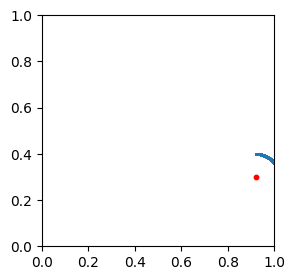

In [202]:
plt.figure(figsize=(3, 3))
plt.scatter(all_sprimes[:, 0], all_sprimes[:, 1], s=0.1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(s[0], s[1], s=10, c='r')

In [203]:
torch.sum(logprobs.exp() * (B - A) / N * env.delta * np.pi / 2 ) + exit_proba

tensor(0.9999, grad_fn=<AddBackward0>)

### Make sure P_F(. | s_0) is a valid proba dist on s'

In [204]:
# evaluate the areas of elements of the quantized disk
def eval_areas(radius, N):
    all_rs = torch.linspace(0, radius, N)
    all_thetas = torch.linspace(0, np.pi / 2, N)
    all_areas = torch.zeros((N - 1, N - 1))
    for i in range(N-1):
        diff_r_2 = all_rs[i+1]**2 - all_rs[i]**2
        for j in range(N-1):
            diff_theta = all_thetas[j+1] - all_thetas[j]
            all_areas[i, j] = 0.5 * diff_r_2 * diff_theta

    return all_areas

In [211]:
def get_riemanian_sum(logprob_fn, radius, N):
    all_rs = torch.linspace(0, radius, N)
    all_thetas = torch.linspace(0, np.pi / 2, N)
    all_areas = eval_areas(radius, N)
    mid_points = torch.zeros((N-1, N-1, 2))
    for i in range(N-1):
        for j in range(N-1):
            mid_points[i, j, 0] = 0.5 * (all_rs[i+1] + all_rs[i])
            mid_points[i, j, 1] = 0.5 * (all_thetas[j+1] + all_thetas[j])

    logprobs = logprob_fn(mid_points[:, :, 0] / radius, mid_points[:, :, 1] / (np.pi / 2))
    return logprobs, all_areas, torch.sum(logprobs.exp() * all_areas)

In [212]:
for N in [10, 50, 100, 200, 500, 700]:
    logprobs, all_areas, riemanian_sum = get_riemanian_sum(lambda r, t: eval_logprobs_s0(r, t, True), env.delta, N)
    print(riemanian_sum)

tensor(0.1012, grad_fn=<SumBackward0>)
tensor(0.1002, grad_fn=<SumBackward0>)
tensor(0.1001, grad_fn=<SumBackward0>)
tensor(0.1000, grad_fn=<SumBackward0>)
tensor(0.1000, grad_fn=<SumBackward0>)
tensor(0.1000, grad_fn=<SumBackward0>)


In [213]:
for N in [10, 50, 100, 200, 500, 700]:
    logprobs, all_areas, riemanian_sum = get_riemanian_sum(lambda r, t: eval_logprobs_s0(r, t, False), env.delta, N)
    print(riemanian_sum)

AttributeError: 'numpy.float64' object has no attribute 'exp'